# Survey coverage and images

## Setup

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import LogNorm
from pathlib import Path
from IPython.display import Image, display

Unfortunately, importing local modules only seems to work from the top directory, not the notebook subdirectory:

In [8]:
import os
os.chdir('/home/colin/code/galaxycnn/proj502')
import projcode
from projcode.data.db import DB
from projcode.data.utils import read_params

params = read_params()
figures_dir = Path(params['coderoot']) / 'project_report/figures'

Utility class for postgres:

In [9]:
db = DB(params)

## Get the positions for the catalogs

First GZ2:

In [29]:
sql = """
    SELECT dr7objid, ra, dec
    FROM gz2data
    WHERE sample = 'original'
    ORDER BY dr7objid 
    """
locs = db.run_select(sql)

gz2 = pd.DataFrame(locs)
gz2.columns = ['dr7id', 'ra', 'dec']

Here, RA is decimal degrees in the range [0, 360]. Mollweide projection needs [-2$\pi$, +2$\pi$] radians.

In [30]:
gz2['ra'].min(), gz2['ra'].max()

(110.56759, 266.12555)

In [31]:
fix_lat = lambda n: ((n+180) % 360) - 180
gz2['long_rad'] = fix_lat(gz2['ra']) * np.pi / 180
gz2['dec_rad'] = gz2['dec'] * np.pi / 180
gz2.head(3)

,dr7id,ra,dec,long_rad,dec_rad
0,587722981741363294,182.92526,-1.092357,-3.090537,-0.019065
1,587722981741363323,182.97011,-1.219537,-3.089754,-0.021285
2,587722981741559888,183.43810,-1.238414,-3.081586,-0.021614


Repeat for DECaLS:

In [32]:
sql = """
    SELECT iauname, ra, dec
    FROM decalsdata
    ORDER BY iauname 
    """
locs = db.run_select(sql)

decals = pd.DataFrame(locs)
decals.columns = ['iauname', 'ra', 'dec']

In [33]:
decals['ra'].min(), decals['ra'].max()

(0.004366900119036308, 359.9979808580347)

In [34]:
decals['long_rad'] = fix_lat(decals['ra']) * np.pi / 180
decals['dec_rad'] = decals['dec'] * np.pi / 180
decals.head(3)

,iauname,ra,dec,long_rad,dec_rad
0,J000000.80+004200.0,359.995016,0.701753,-0.000087,0.012248
1,J000001.03+003228.7,0.004367,0.541321,0.000076,0.009448
2,J000001.55-000533.3,0.006467,-0.092602,0.000113,-0.001616


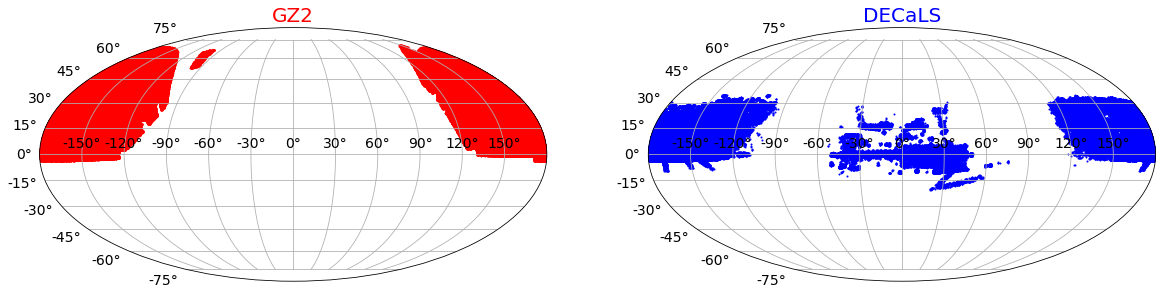

In [39]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(20,10))
ax1 = plt.subplot(121, projection="mollweide")
ax1.scatter(gz2['long_rad'], gz2['dec_rad'], s=1, c='r')
ax1.grid(True)
ax1.set_title('GZ2', size=20, color='r')
ax2 = plt.subplot(122, projection="mollweide")
ax2.scatter(decals['long_rad'], decals['dec_rad'], s=1, c='b')
ax2.grid(True);
ax2.set_title('DECaLS', size=20, color='b')
# plt.savefig(figures_dir / 'coverage.pdf')
# plt.savefig(figures_dir / 'coverage.png')

## Look for matches

Add a new string column to each table.

In [17]:
sql = """ALTER TABLE IF EXISTS public.decalsdata
    ADD COLUMN IF NOT EXISTS pos_str character(20)"""
db.run_admin(sql)

In [18]:
sql = """ALTER TABLE IF EXISTS public.gz2matchesdata
    ADD COLUMN IF NOT EXISTS pos_str character(20)"""
db.run_admin(sql)

Convert floating point values to fixed-format string and insert.

This is slow but easy. TODO - find an all-SQL way to do it in one go.

In [19]:
sql = """SELECT dr7objid, ra, dec FROM gz2data"""
gz2 = db.run_select(sql)

for (dr7id, ra, dec) in gz2:
    sql = f"UPDATE gz2data SET pos_str='{ra:.3f}_{dec:.3f}' WHERE dr7objid={dr7id}"
    db.run_admin(sql)

In [20]:
sql = """SELECT iauname, ra, dec FROM decalsdata"""
decals = db.run_select(sql)

for (iauname, ra, dec) in decals:
    sql = f"UPDATE decalsdata SET pos_str='{ra:.3f}_{dec:.3f}' WHERE iauname='{iauname}'"
    db.run_admin(sql)

A query `matches`was defined like this:

``` 
SELECT 
    gz.dr7objid,
    d.iauname,
    d.ra,
    d."dec",
    d.pos_str
FROM decalsdata d,
     gz2data gz
WHERE d.pos_str = gz.pos_str;
```

Another, `path2matches`, has this definition:

```
 SELECT m.dr7objid,
    m.iauname,
    i1.path AS gz2_path,
    i2.path AS decals_path
   FROM matches m,
    img i1,
    img i2
  WHERE m.dr7objid::text = i1.id_str AND m.iauname = i2.id_str;
  ```
  
The latter is slow and inefficient (joining on a computed field is nobody's idea of best practice), but good enough for one-off use.

In [21]:
sql = """
SELECT dr7objid, iauname, gz2_path, decals_path
FROM path2matches
LIMIT 5000
"""
matches = db.run_select(sql)

Define a plotting routine to call within a loop:

In [22]:
def plot_pair(img1, im2, id1, id2):
    fig = plt.figure(figsize=(16,18))
    plt.ioff()

    ax1 = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(img1)
    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.set_title(id1)

    ax2 = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(img2)
    imgplot.set_clim(0.0, 0.7)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_title(id2)
    plt.savefig(figures_dir / f'{id2}.pdf', bbox_inches='tight')
    plt.close(fig)

Generate some image pairs:

In [23]:
for (dr7objid, iauname, gz2_path, decals_path) in matches[:3000:1000]:
    img1 = mpimg.imread(gz2_path)
    img2 = mpimg.imread(decals_path)
    plot_pair(img1, img2, dr7objid, iauname)

In [24]:
for (dr7objid, iauname, gz2_path, decals_path) in matches[:3000:1000]:
    print(gz2_path, decals_path)

/home/colin/data/munch1tb/zoobot_data/gzimg/sdssdr7/588848900980736134.jpg /home/colin/data/munch1tb/zoobot_data/gz_decals_dr5_png/J110/J110821.70+004921.7.png
/home/colin/data/munch1tb/zoobot_data/gzimg/sdssdr7/588848900980342922.jpg /home/colin/data/munch1tb/zoobot_data/gz_decals_dr5_png/J110/J110426.68+003939.5.png
/home/colin/data/munch1tb/zoobot_data/gzimg/sdssdr7/587738409795846324.jpg /home/colin/data/munch1tb/zoobot_data/gz_decals_dr5_png/J110/J110933.02+134944.8.png


## Add zoomed SDSS images

After repeating cutout retrieval at 0.1 arcsec/pixel, add these to the plot:

In [25]:
def plot_trio(img1a, img1b, im2, id1, id2):
    fig = plt.figure(figsize=(16,18))
    plt.ioff()

    ax1a = fig.add_subplot(1, 3, 1)
    imgplot = plt.imshow(img1a)
    ax1a.get_xaxis().set_visible(False)
    ax1a.get_yaxis().set_visible(False)
    ax1a.set_title(id1)

    ax1b = fig.add_subplot(1, 3, 2)
    imgplot = plt.imshow(img1b)
    ax1b.get_xaxis().set_visible(False)
    ax1b.get_yaxis().set_visible(False)
    ax1b.set_title(id1)

    ax2 = fig.add_subplot(1, 3, 3)
    imgplot = plt.imshow(img2)
    imgplot.set_clim(0.0, 0.7)
    ax2.get_xaxis().set_visible(False)
    ax2.get_yaxis().set_visible(False)
    ax2.set_title(id2)
    plt.savefig(figures_dir / f'{id2}_3.pdf', bbox_inches='tight')
    plt.close(fig)

In [26]:
for (dr7objid, iauname, gz2_path, decals_path) in matches[:20]:
    img1a = mpimg.imread(gz2_path.replace('gzimg', 'gz2_bad_images'))
    img1b = mpimg.imread(gz2_path)
    img2 = mpimg.imread(decals_path)
    plot_trio(img1a, img1b, img2, dr7objid, iauname)

Hack to recover an old galaxy and update the PDF file:

In [42]:
fmatch =[match for match in matches if match[0] == 588848901516689605] 
fmatch

[(588848901516689605,
  'J110001.05+010644.0',
  '/home/colin/data/munch1tb/zoobot_data/gzimg/sdssdr7/588848901516689605.jpg',
  '/home/colin/data/munch1tb/zoobot_data/gz_decals_dr5_png/J110/J110001.05+010644.0.png'),
 (588848901516689605,
  'J110001.05+010644.0',
  '/home/colin/data/munch1tb/zoobot_data/gzimg/sdsspng/588848901516689605.png',
  '/home/colin/data/munch1tb/zoobot_data/gz_decals_dr5_png/J110/J110001.05+010644.0.png')]

In [43]:
for (dr7objid, iauname, gz2_path, decals_path) in fmatch:
    img1a = mpimg.imread(gz2_path.replace('gzimg', 'gz2_bad_images'))
    img1b = mpimg.imread(gz2_path)
    img2 = mpimg.imread(decals_path)
    plot_trio(img1a, img1b, img2, dr7objid, iauname)